In [1]:
import numpy as np

T = 50
N = 10000
R = 1
Q = 10
x_init = np.random.normal(0, 1)
def cree_trajectoire(Q,T,x_init) :
    vecteur_x = np.zeros((1,T))
    vecteur_x[:,0] = x_init
    for j in range(1,T) :
        U = np.random.normal(0, Q)
        temp = 0.5*vecteur_x[:,j-1] + 25*(vecteur_x[:,j-1]/(1 + vecteur_x[:,j-1]**2)) + 8*np.cos(1.2*(j))
        vecteur_x[:,j] = temp + U
        
    return vecteur_x

vecteur_x = cree_trajectoire(Q,T,x_init)

def creer_observations(R,T,vecteur_x):
    vecteur_y = np.zeros((1,T))
    V = np.random.normal(0,R)
    for i in range(0,T) :
        V = np.random.normal(0,R)
        vecteur_y[:,i] = vecteur_x[:,i]**2/20 + V
    return vecteur_y

vecteur_y = creer_observations(R,T,vecteur_x)

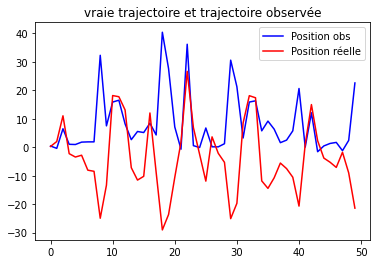

In [3]:
import matplotlib.pyplot as plt 

plt.plot(vecteur_y.flatten(),label='Position obs',color='blue')
plt.plot(vecteur_x.flatten(),label='Position réelle',color='red')
plt.title('vraie trajectoire et trajectoire observée')
plt.legend()
plt.show()

In [9]:
# Q 5 
from scipy.stats import norm



def filtrage_particulaire(vecteur_y,R,Q,N) : 
    X = np.zeros((N,T))
    X_est = np.zeros((1,T))
    W = np.zeros((N,T))

    X_t = np.random.randn(N,1)
    w_t = norm.pdf(vecteur_y[0][0],(X_t**2)/20,R) # calcul (P(y_0|x_0^1 ), ... ,P(y_0|x_0^N))
    w_t=w_t/(w_t.sum())
    W[:,0] = w_t.flatten()
    X[:,0] = X_t.T
    #X_est[0] = (W[:,0]*X[:,0]).sum()
    for t in range(1,T) : 
        A = np.random.choice(range(N),N,p=w_t.flatten())
        reech = X_t[A]
        X_t = 0.5*reech + 25*reech/(1+ reech**2) + 8*np.cos(1.2*(t)) + np.random.normal(0, Q, (N,1))
        w_t = norm.pdf(vecteur_y[0][t],X_t**2/20,R)
        w_t = w_t/(w_t.sum())
        #print(w_t)
        W[:,t] = w_t.flatten()
        X[:,t] = X_t.T
        #X_est[:,t] = (W[:,t]*X[:,t]).sum()
    X_est = (W*X).sum(0)
    return X_est

X_est=filtrage_particulaire(vecteur_y=vecteur_y,R=R,Q=Q,N=10000)



In [ ]:
# Cassiop 


In [47]:
X_est

array([-4.38542963e-03,  1.47166527e-01, -4.04056155e-01, -2.23502475e+00,
       -3.08372832e+00,  1.47663984e-01,  1.01812879e+01,  2.73129097e+00,
       -2.70855006e+01, -1.59933080e+01, -4.29472881e-01,  1.04979165e+00,
        3.56396707e-02, -1.39991145e-01, -1.61871403e+00,  6.25840712e+00,
        1.25762814e+01,  3.22983558e-01, -1.70325085e-01, -9.90093596e-01,
        4.49925767e-02,  1.45086419e+01,  2.40968118e+00, -5.12777357e-02,
       -4.32312568e-01,  2.26171934e+00,  8.22734654e+00,  9.91252917e+00,
        2.69329224e-01, -4.17393247e+01, -5.22896130e+00,  5.98881531e-02,
        4.63994317e+00, -2.71074325e+00,  5.29624394e-01, -3.45745891e-01,
        1.33717946e+01,  1.52579413e+01,  3.09672122e+00, -5.40029508e-01,
       -2.01680974e+00,  1.13444989e+00,  3.58374431e+00,  1.56228925e+00,
       -3.20515231e+01, -2.34194662e+01, -1.42812177e+01, -1.00536054e+00,
       -2.17558644e-01, -3.35179038e-01])

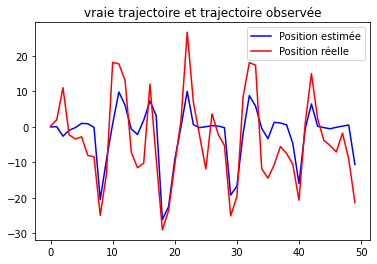

In [10]:
plt.plot(X_est.flatten(),label='Position estimée',color='blue')
plt.plot(vecteur_x.flatten(),label='Position réelle',color='red')
plt.title('vraie trajectoire et trajectoire observée')
plt.legend()
plt.show()

In [7]:
def erreur_quadra(k) :
    x_k = vecteur_x[0][k]
    vecteur_y_k = vecteur_y[0][k]
    A = (x_k - vecteur_y_k)
    return A**2

def erreur_moyenne():
    sum=0
    for k in range(T):
        sum+=erreur_quadra(k)
    
    return (1/T)*sum

test = erreur_moyenne()
test

551.1046678611606

In [8]:
def erreur_quadra(k) :
    x_k = vecteur_x[0][k]
    x_hat_k = X_est[k]
    A = (x_k - x_hat_k)
    return A**2

def erreur_moyenne():
    sum=0
    for k in range(T):
        sum+=erreur_quadra(k)
    
    return (1/T)*sum

test = erreur_moyenne()
test

61.03392634281895

Partie 2 

In [13]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import matplotlib.image as mpimg
from PIL import Image
import math
from scipy.stats import norm
from numpy.random import random
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
import os
N = 50 
Nb = 10
lamb = 20
C1 = 300
C2 = 300

In [16]:
def multinomial_resample(weights):
    """ This is the naive form of roulette sampling where we compute the
    cumulative sum of the weights and then use binary search to select the
    resampled point based on a uniformly distributed random number. Run time
    is O(n log n). You do not want to use this algorithm in practice; for some
    reason it is popular in blogs and online courses so I included it for
    reference.
   Parameters
   ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    weights=weights.T
    cumulative_sum = np.cumsum(weights)
    #cumulative_sum[-1] = 1.  # avoid round-off errors: ensures sum is exactly one
    #print ( np.searchsorted(cumulative_sum, random(len(weights))))
    return np.searchsorted(cumulative_sum, random(len(weights)))


def lecture_image() :

    SEQUENCE = "./images/"
    START = 1
    #charge le nom des images de la sÃ©quence
    filenames = os.listdir(SEQUENCE)
    T = len(filenames)
    #print(T)
    #print(filenames)
    #charge la premiere image dans â€™imâ€™
    tt = 45
   # print(str(SEQUENCE)+str(filenames[tt]))
    #im = mpimg.imread(str(SEQUENCE)+str(filenames[tt]))
    im=Image.open((str(SEQUENCE)+str(filenames[tt])))
    #affiche â€™imâ€™
    #fig = figure;
    #set(fig,'Units','Normalized','Position',[0 0 1 1]);
    #set(gcf, 'DoubleBuffer', 'on') ;
    plt.imshow(im)
    
    #plt.show()
    


    
    return(im,filenames,T,SEQUENCE)

def selectionner_zone() :

    #lecture_image()
    print('Cliquer 4 points dans l image pour definir la zone a suivre.') ;
    zone = np.zeros([2,4])
 #   print(zone)
    compteur=0
    while(compteur != 4):
        res = plt.ginput(1)
        a=res[0]
        #print(type(a))
        zone[0,compteur] = a[0]
        zone[1,compteur] = a[1]   
        plt.plot(a[0],a[1],marker='X',color='red') 
        compteur = compteur+1 

    #print(zone)
    newzone = np.zeros([2,4]) ;
    newzone[0, :] = np.sort(zone[0, :]) 
    newzone[1, :] = np.sort(zone[1, :])
    
    zoneAT = np.zeros([4])
    zoneAT[0] = newzone[0,0]
    zoneAT[1] = newzone[1,0]
    zoneAT[2] = newzone[0,3]-newzone[0,0] 
    zoneAT[3] = newzone[1,3]-newzone[1,0] 
    #affichage du rectangle
    #print(zoneAT)
    xy=(zoneAT[0],zoneAT[1])
    rect=ptch.Rectangle(xy,zoneAT[2],zoneAT[3],linewidth=3,edgecolor='red',facecolor='None') 
    #plt.Rectangle(zoneAT[0:1],zoneAT[2],zoneAT[3])
    currentAxis = plt.gca()
    currentAxis.add_patch(rect)
    plt.show(block=False)
    return(zoneAT)


def rgb2ind(im,nb) :
    #nb = nombre de couleurs ou kmeans qui contient la carte de couleur de l'image de rÃ©fÃ©rence
    
    image=np.array(im,dtype=np.float64)/255
    w,h,d=original_shape=tuple(image.shape)
    image_array=np.reshape(image,(w*h,d))
    image_array_sample=shuffle(image_array,random_state=0)[:1000]
   # print(type(image_array))
    if type(nb)==int :
        kmeans=KMeans(n_clusters=nb,random_state=0).fit(image_array_sample)
    else :
        kmeans=nb
            
    labels=kmeans.predict(image_array)
    #print(labels)
    image=recreate_image(kmeans.cluster_centers_,labels,w,h)
    #print(image)
    return(Image.fromarray(image.astype('uint8')),kmeans)

def recreate_image(codebook,labels,w,h):
    d=codebook.shape[1]
    #image=np.zeros((w,h,d))
    image=np.zeros((w,h))
    label_idx=0
    for i in range(w):
        for j in range(h):
            #image[i][j]=codebook[labels[label_idx]]*255
            image[i][j]=labels[label_idx]
            #print(image[i][j])
            label_idx+=1

    return image



def calcul_histogramme(im,zoneAT,Nb):

  #  print(zoneAT)
    box=(zoneAT[0],zoneAT[1],zoneAT[0]+zoneAT[2],zoneAT[1]+zoneAT[3])
   # print(box)
    littleim = im.crop(box)
##    plt.imshow(littleim)
##    plt.show()
    new_im,kmeans= rgb2ind(littleim,Nb)
    histogramme=np.asarray(new_im.histogram())
##  print(histogramme)
    histogramme=histogramme/np.sum(histogramme)
  #  print(new_im)
    return (new_im,kmeans,histogramme)

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x384 at 0x26C998737F0>,
 ['im01.png',
  'im02.png',
  'im03.png',
  'im04.png',
  'im05.png',
  'im06.png',
  'im07.png',
  'im08.png',
  'im09.png',
  'im10.png',
  'im11.png',
  'im12.png',
  'im13.png',
  'im14.png',
  'im15.png',
  'im16.png',
  'im17.png',
  'im18.png',
  'im19.png',
  'im20.png',
  'im21.png',
  'im22.png',
  'im23.png',
  'im24.png',
  'im25.png',
  'im26.png',
  'im27.png',
  'im28.png',
  'im29.png',
  'im30.png',
  'im31.png',
  'im32.png',
  'im33.png',
  'im34.png',
  'im35.png',
  'im36.png',
  'im37.png',
  'im38.png',
  'im39.png',
  'im40.png',
  'im41.png',
  'im42.png',
  'im43.png',
  'im44.png',
  'im45.png',
  'im46.png'],
 46,
 './images/')

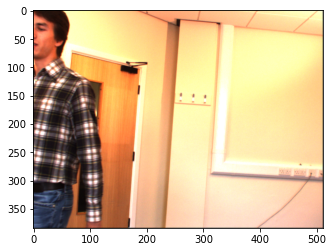

In [17]:
lecture_image()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate a range of x values to plot the PDF
x = np.linspace(-5, 5, 100)

# Evaluate the PDF at each value of x
y = norm.pdf(x, 0, 1)

y


array([1.48671951e-06, 2.45106104e-06, 3.99989037e-06, 6.46116639e-06,
       1.03310066e-05, 1.63509589e-05, 2.56160812e-05, 3.97238224e-05,
       6.09759040e-05, 9.26476353e-05, 1.39341123e-04, 2.07440309e-04,
       3.05686225e-04, 4.45889725e-04, 6.43795498e-04, 9.20104770e-04,
       1.30165384e-03, 1.82273110e-03, 2.52649578e-03, 3.46643792e-03,
       4.70779076e-03, 6.32877643e-03, 8.42153448e-03, 1.10925548e-02,
       1.44624148e-02, 1.86646099e-02, 2.38432745e-02, 3.01496139e-02,
       3.77369231e-02, 4.67541424e-02, 5.73380051e-02, 6.96039584e-02,
       8.36361772e-02, 9.94771388e-02, 1.17117360e-01, 1.36486009e-01,
       1.57443188e-01, 1.79774665e-01, 2.03189836e-01, 2.27323506e-01,
       2.51741947e-01, 2.75953371e-01, 2.99422683e-01, 3.21590023e-01,
       3.41892294e-01, 3.59786558e-01, 3.74773979e-01, 3.86422853e-01,
       3.94389234e-01, 3.98433802e-01, 3.98433802e-01, 3.94389234e-01,
       3.86422853e-01, 3.74773979e-01, 3.59786558e-01, 3.41892294e-01,
      